# 1 Understand the Data Structure

In [1]:
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

os.chdir('../data/raw')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB


### 1.1 Check how many unique stores, countries, and product exist

In [2]:
# Stores
print(
    f"Train: \n{train.store.value_counts()}", 
    f"\n====\nTest:\n {test.store.value_counts()}"
    )

Train: 
store
Discount Stickers       76710
Stickers for Less       76710
Premium Sticker Mart    76710
Name: count, dtype: int64 
====
Test:
 store
Discount Stickers       32850
Stickers for Less       32850
Premium Sticker Mart    32850
Name: count, dtype: int64


In [3]:
# Countries
print(
    f"Train: \n{train.country.value_counts()}", 
    f"\n====\nTest:\n {test.country.value_counts()}"
    )

Train: 
country
Canada       38355
Finland      38355
Italy        38355
Kenya        38355
Norway       38355
Singapore    38355
Name: count, dtype: int64 
====
Test:
 country
Canada       16425
Finland      16425
Italy        16425
Kenya        16425
Norway       16425
Singapore    16425
Name: count, dtype: int64


In [4]:
# Products 
print(
    f"Train: \n{train['product'].value_counts()}", 
    f"\n====\nTest:\n {test['product'].value_counts()}"
    )

Train: 
product
Holographic Goose     46026
Kaggle                46026
Kaggle Tiers          46026
Kerneler              46026
Kerneler Dark Mode    46026
Name: count, dtype: int64 
====
Test:
 product
Holographic Goose     19710
Kaggle                19710
Kaggle Tiers          19710
Kerneler              19710
Kerneler Dark Mode    19710
Name: count, dtype: int64


<div style="padding: 20px 12px; background-color: lightcyan; color: darkcyan; font-weight: bold"> The stores, countries, and products are divided equally... </div>

### 1.2 Identify the time range of training vs test data

In [5]:
# Dates
print(
    f"Train: \n{train['date'].agg(['min', 'max'])}", 
    f"\n====\nTest:\n {test['date'].agg(['min', 'max'])}"
    )

Train: 
min    2010-01-01
max    2016-12-31
Name: date, dtype: object 
====
Test:
 min    2017-01-01
max    2019-12-31
Name: date, dtype: object


<div style="padding: 20px 12px; background-color: lightcyan; color: darkcyan; font-weight: bold">
    The time range for training set is from the beginning of 2010 to the end of 2016 (7 years) while for the test set, it is from 2017 to the end of 2019 (2 years).
</div>

### 1.3 Verify date frequency

In [6]:
train['date'].value_counts()

date
2016-12-31    90
2010-01-01    90
2010-01-02    90
2010-01-03    90
2010-01-04    90
              ..
2010-01-18    90
2010-01-17    90
2010-01-16    90
2010-01-15    90
2010-01-14    90
Name: count, Length: 2557, dtype: int64

In [7]:
test['date'].value_counts()

date
2019-12-31    90
2017-01-01    90
2017-01-02    90
2017-01-03    90
2017-01-04    90
              ..
2017-01-12    90
2017-01-11    90
2017-01-10    90
2017-01-09    90
2017-01-08    90
Name: count, Length: 1095, dtype: int64

<div style="padding: 20px 12px; background-color: lightcyan; color: darkcyan; font-weight: bold">
    For each day, there are 90 occurrences.
</div>

# 2 Data Cleaning

In [8]:
print("Missing values in train set: \n", train.isnull().sum()) 
print("\n\nMissing values in test set: \n", test.isnull().sum())

Missing values in train set: 
 id             0
date           0
country        0
store          0
product        0
num_sold    8871
dtype: int64


Missing values in test set: 
 id         0
date       0
country    0
store      0
product    0
dtype: int64


So, the missing values are only in the num_sold column

In [9]:
# Group by store-country-product and count missing values
missing_by_group = train.groupby(['store', 'country', 'product'])['num_sold'].agg(
    total_count=lambda x: x.size,
    missing_count=lambda x: x.isna().sum()
).reset_index()

# Sort descending to see worst-affected groups
missing_by_group = missing_by_group.sort_values('missing_count', ascending=False)

# Find all groups with missing values
affected_groups = missing_by_group[missing_by_group['missing_count'] > 0]

print(f"Total groups with missing data: {len(affected_groups)}")
affected_groups.head(len(affected_groups))

Total groups with missing data: 9


,store,country,product,total_count,missing_count
0,Discount Stickers,Canada,Holographic Goose,2557,2557
15,Discount Stickers,Kenya,Holographic Goose,2557,2557
75,Stickers for Less,Kenya,Holographic Goose,2557,1358
60,Stickers for Less,Canada,Holographic Goose,2557,1308
45,Premium Sticker Mart,Kenya,Holographic Goose,2557,646
30,Premium Sticker Mart,Canada,Holographic Goose,2557,380
18,Discount Stickers,Kenya,Kerneler,2557,63
19,Discount Stickers,Kenya,Kerneler Dark Mode,2557,1
3,Discount Stickers,Canada,Kerneler,2557,1


<details>
<summary>Let's break "handling the missing values" down <b>conceptually</b> in three clear steps:</summary>
    <h4><strong>1. Categorize Missing Values by Nature</strong></h4>
    <p>Based on the table, there are <strong>three distinct types</strong> of missing values:</p>

<table>
    <tr>
        <th>Type</th>
        <th>Example Groups</th>
        <th>Missing Pattern</th>
        <th>Likely Cause</th>
    </tr>
    <tr>
        <td><strong>A</strong></td>
        <td>Discount Stickers (Canada/Kenya) - Holographic Goose</td>
        <td>100% missing (2557/2557 days)</td>
        <td>Product <strong>never available</strong> during 2010-2016</td>
    </tr>
    <tr>
        <td><strong>B</strong></td>
        <td>Stickers for Less (Kenya/Canada) - Holographic Goose</td>
        <td>~50% missing</td>
        <td><strong>Temporary unavailability</strong> or data collection gaps</td>
    </tr>
    <tr>
        <td><strong>C</strong></td>
        <td>Kerneler products in Kenya/Canada</td>
        <td>1-63 missing days</td>
        <td><strong>Random gaps</strong> (human error, system glitches)</td>
    </tr>
</table>

<br>

<h4><strong>2. Handle Each Type Differently</strong></h4>
<h5><strong>Type A (Systemic Unavailability)</strong></h5>
<ul>
    <li><strong>Action:</strong> Treat as <strong>true zeros</strong> (<code>num_sold=0</code>)</li>
    <li><strong>Why:</strong></li>
    <ul>
        <li>Test set includes these groups &rarr; product launches in 2017-2019</li>
        <li>Model needs to learn "no sales until availability starts"</li>
    </ul>
    <li><strong>Add Feature:</strong> <code>is_available</code> (0 for these groups in 2010-2016, 1 elsewhere)</li>
</ul>

<h5><strong>Type B (Temporary Gaps)</strong></h5>
<ul>
    <li><strong>Action:</strong></li>
    <ol>
        <li>Forward-fill short gaps (&lt;7 days)</li>
        <li>For longer gaps, use <strong>same-store-country-product median</strong></li>
    </ol>
    <li><strong>Why:</strong></li>
    <ul>
        <li>Preserves temporal consistency</li>
        <li>Avoids overfitting to noise</li>
    </ul>
    <li><strong>Add Feature:</strong> <code>gap_length</code> (days since last observed sale)</li>
</ul>

<h5><strong>Type C (Random Gaps)</strong></h5>
<ul>
    <li><strong>Action:</strong> Use <strong>linear interpolation</strong> (neighboring days' average)</li>
    <li><strong>Why:</strong></li>
    <ul>
        <li>Minimal impact on overall trends</li>
        <li>Simple and conservative</li>
    </ul>
</ul>

<br>

<h4><strong>3. Critical Feature Engineering</strong></h4>
<p>Add these to help models understand missingness context:</p>
<ol>
    <li><code>is_available</code>: Binary flag for systemic unavailability (Type A)</li>
    <li><code>days_since_last_sale</code>: For Type B gaps &rarr; helps model detect recovery patterns</li>
    <li><code>imputation_method</code>: Categorical feature indicating:</li>
    <ul>
        <li>0: No imputation</li>
        <li>1: Systemic zero (Type A)</li>
        <li>2: Median fill (Type B)</li>
        <li>3: Linear interpolation (Type C)</li>
    </ul>
</ol>

<br>

<h4><strong>Why This Works for MAPE</strong></h4>
<ul>
    <li><strong>Type A:</strong> True zeros avoid infinite MAPE penalties if test set has post-2016 sales</li>
    <li><strong>Type B/C:</strong> Median/interpolation provides stable baselines instead of extreme guesses</li>
    <li><strong>Feature Flags:</strong> Allow models to weight predictions based on data quality</li>
</ul>

</details>

### 2.1 Handling missing values

Handle Type A (systemic unavailability)

In [10]:
# Create mask for Type A groups
type_a_mask = (
    (train['store'] == 'Discount Stickers') &
    (train['country'].isin(['Canada', 'Kenya'])) &
    (train['product'] == 'Holographic Goose')
)

# Set num_sold to 0 and create availability flag
train.loc[type_a_mask, 'num_sold'] = 0
train['is_available'] = np.where(type_a_mask, 0, 1)

Handle Type B (Temporary Gaps)

In [11]:
# Define Type B groups
type_b_groups = [
    ('Stickers for Less', 'Kenya', 'Holographic Goose'),
    ('Stickers for Less', 'Canada', 'Holographic Goose'),
    ('Premium Sticker Mart', 'Kenya', 'Holographic Goose'),
    ('Premium Sticker Mart', 'Canada', 'Holographic Goose')
]

# Sort data chronologically per group
train = train.sort_values(by=['store', 'country', 'product', 'date'])

for store, country, product in type_b_groups:
    # Get group mask
    mask = (
        (train['store'] == store) &
        (train['country'] == country) &
        (train['product'] == product)
    )
    
    # Calculate median for the group
    group_median = train.loc[mask, 'num_sold'].median()
    
    # Fill missing values
    train.loc[mask, 'num_sold'] = train.loc[mask, 'num_sold'].fillna(group_median)
    
    # Add gap length feature
    train.loc[mask, 'gap_length'] = train.loc[mask, 'num_sold'].isna().groupby(mask).cumsum()

Handle Type C (Random Gaps)

In [12]:
# Group by store-country-product
grouped = train.groupby(['store', 'country', 'product'])

# Linear interpolation for remaining missing values
train['num_sold'] = grouped['num_sold'].transform(
    lambda x: x.interpolate(method='linear', limit_direction='both')
)

# Mark imputation method
train['imputation_method'] = np.select(
    [
        type_a_mask,
        train['num_sold'].isna(),  # Will be handled by next line
        train['gap_length'] > 0
    ],
    [
        'systemic_zero', 
        'linear_interpolation',
        'median_fill'
    ],
    default='no_imputation'
)

# Final check for remaining missing values
assert train['num_sold'].isna().sum() == 0, "Missing values remain!"

## Quick feature engineering & modelling

In [13]:
import lightgbm as lgb

In [14]:
# Basic Temporal Features (Safe)
train['date'] = pd.to_datetime(train['date'])
train['day_of_week'] = train['date'].dt.dayofweek
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year
train['is_weekend'] = (train['day_of_week'] >= 5).astype(int)

### Match test & train sets

In [15]:
# 1. Basic Temporal Features (Same as train set)
test['date'] = pd.to_datetime(test['date'])
test['day_of_week'] = test['date'].dt.dayofweek
test['month'] = test['date'].dt.month
test['year'] = test['date'].dt.year
test['is_weekend'] = (test['day_of_week'] >= 5).astype(int)

# 2. Add Missing Columns (If needed)
# If test set doesn't have these columns, initialize them
if 'is_available' not in test.columns:
    test['is_available'] = 1  # Assume available unless specified otherwise

if 'imputation_method' not in test.columns:
    test['imputation_method'] = 'no_imputation'  # Default value

# 3. Convert Categoricals (Same as train set)
for col in ['store', 'country', 'product', 'imputation_method']:
    test[col] = test[col].astype('category')

# 4. Verify Feature Alignment
train_features = set(train.columns)
test_features = set(test.columns)
missing_in_test = train_features - test_features
extra_in_test = test_features - train_features

print("Missing in test:", missing_in_test)
print("Extra in test:", extra_in_test)

Missing in test: {'num_sold', 'gap_length'}
Extra in test: set()


### Pre-processing and modelling

In [16]:
# Create validation split with .copy() to avoid warnings
val_cutoff = train['date'].max() - pd.DateOffset(years=1)
train_data = train[train['date'] < val_cutoff].copy()  # Explicit copy
val_data = train[train['date'] >= val_cutoff].copy()    # Explicit copy

# Convert categoricals safely
for col in ['store', 'country', 'product', 'imputation_method']:
    train_data[col] = train_data[col].astype('category')
    val_data[col] = val_data[col].astype('category')

# Simple model test
features = [
    'country', 'store', 'product', 'num_sold', 'is_available', 
    'day_of_week', 'month', 'year', 'is_weekend', 'imputation_method'
    ]
model = lgb.LGBMRegressor(objective='mape', num_leaves=31, n_estimators=100)
model.fit(train_data[features], train_data['num_sold'],
          eval_set=[(val_data[features], val_data['num_sold'])])

[LightGBM] [Warning] Some label values are < 1 in absolute value. MAPE is unstable with such values, so LightGBM rounds them to 1.0 when calculating MAPE.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 306
[LightGBM] [Info] Number of data points in the train set: 197100, number of used features: 10


LGBMRegressor(objective='mape')

## Key Steps

             Feature  Importance
0            country           0
1              store         132
2            product         112
3           num_sold        2315
4       is_available           0
5        day_of_week          45
6              month         146
7               year         250
8         is_weekend           0
9  imputation_method           0


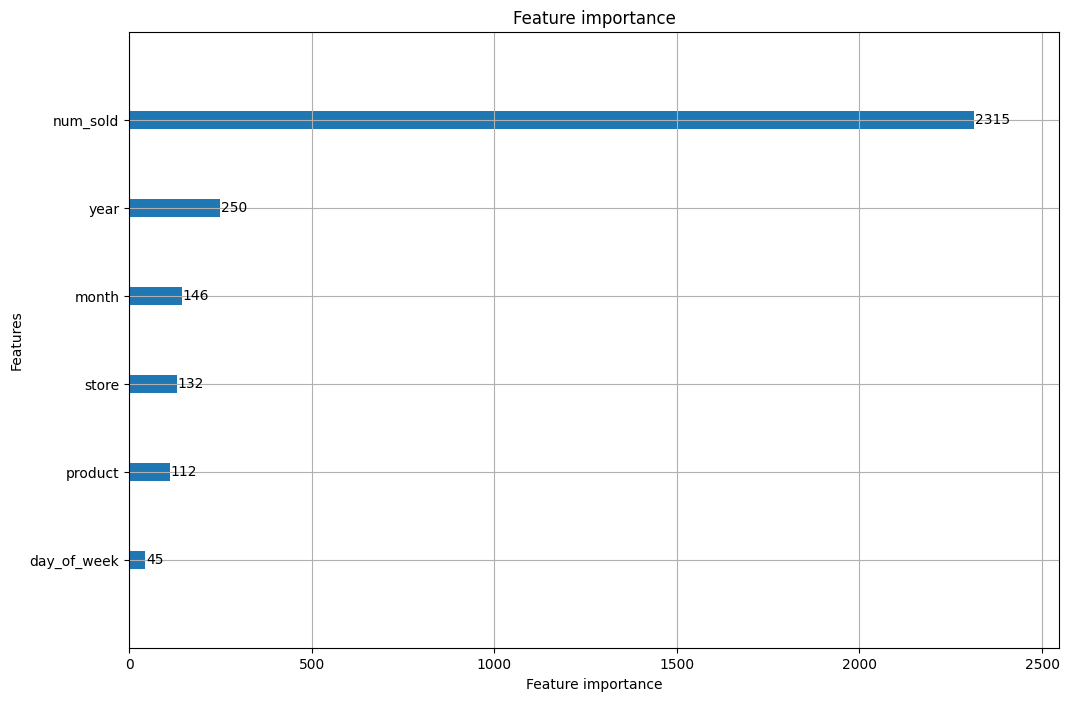

In [17]:
# Feature importance check
feature_importances = pd.DataFrame({'Feature': model.booster_.feature_name(),
                                    'Importance': model.feature_importances_})
lgb.plot_importance(model, figsize=(12, 8), max_num_features=20)
print(feature_importances)
plt.show()

In [18]:
train = train[[
    'id', 'date', 'country', 'store', 'product', 'num_sold', 
    'is_available', 'imputation_method', 'day_of_week', 'month', 'year','is_weekend'
    ]]

In [19]:
print(train.columns, "\n", test.columns)

Index(['id', 'date', 'country', 'store', 'product', 'num_sold', 'is_available',
       'imputation_method', 'day_of_week', 'month', 'year', 'is_weekend'],
      dtype='object') 
 Index(['id', 'date', 'country', 'store', 'product', 'day_of_week', 'month',
       'year', 'is_weekend', 'is_available', 'imputation_method'],
      dtype='object')


In [20]:
test = test[[
    'id', 'date', 'country', 'store', 'product', 'day_of_week', 'month',
    'year', 'is_weekend', 'is_available',
]]

In [21]:
# save cleaned data
os.chdir('../cleaned')
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)